In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## load the libraries 
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input, LSTM, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from collections import Counter
from keras import  Model, models, layers, optimizers, regularizers
import pandas as pd
import numpy as np
import warnings
import os
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score
from tensorflow.keras import layers
from itertools import repeat
from time import perf_counter
from tensorflow.keras.metrics import BinaryAccuracy, AUC
from tensorflow.python.client import device_lib
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
pd.set_option('display.max_columns', None)
tf.keras.backend.set_floatx('float32')

In [ ]:
cols = {'obj': [],
        'cat': [],
       'cont': []
        }
def data_split():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/'
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    # 데이터 유형별 분류하기
    for dt_idx, dt_val in zip(df.dtypes.index, df.dtypes.values):
        if dt_val == 'object':
            if ('id' in dt_idx) | ('time' in dt_idx) | ('name' in dt_idx) | ('keyword' in dt_idx) |('url' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                cols['obj'].append(dt_idx)

        else:
            if ('id' in dt_idx) | ('time' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                if len(df[dt_idx].value_counts()) <= 30: #연속형 데이터 중 30개 내의 범주로 나눌 수 있는 데이터 = category로 구분.
                    cols['cat'].append(dt_idx)
                else:
                    if ('hour' in dt_idx) | ('group' in dt_idx):
                        pass
                    else:
                        cols['cont'].append(dt_idx) 

    return cols

In [ ]:
def reorganization(df):
  data = pd.DataFrame()
  cols = data_split()
  for k, v in cols.items():
    if k == 'obj':
      data = pd.concat([data, df[v]], axis=1)
    elif k == 'cont':
      data = pd.concat([data, df[v]], axis=1)
    else:
      data = pd.concat([data, df[v]], axis=1)

  return data

In [ ]:
def preprocessing():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)
    
    # 데이터 유형별 분류하기
    data = reorganization(df)
    modified_df = pd.DataFrame()

    for i, c in enumerate(data.columns):
        if c in cols['obj']:
            obj_data = pd.get_dummies(data[c], prefix=c, prefix_sep = "/")
            modified_df = pd.concat([modified_df, obj_data], axis=1)

        elif c in cols['cat']:  # click_label 컬럼 = y 변수로 사용
            if 'click' in c:
                pass
            else:
                cat_data = pd.get_dummies(data[c], prefix=c, prefix_sep = "/")
                modified_df = pd.concat([modified_df, cat_data], axis=1)
        else:
            scaled_num_data = MinMaxScaler().fit_transform(df[[c]])
            scaled_num_data = pd.DataFrame(scaled_num_data, columns = [c])
            modified_df = pd.concat([modified_df,scaled_num_data], axis=1)
            
    print('---- Data info ----')
    print(cols)
    print('Data Frame shape: {}'.format(modified_df.shape))
    
    return modified_df

In [ ]:
# 데이터 7:3으로 나누기 (검증 데이터는 8:2)
def split_data():

  ### read dataset 
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    modified_df = preprocessing()

    X = modified_df.values
    y = df['click_label'].values
  
    # split the train/test data (7:3 ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2022, stratify = y) #y 비율에 따른 층화추출 및 데이터를 7:3의 비율로 나누기
    print(f"# of train_data's rows: {X_train.shape[0]} \n# of test_data's rows: {X_test.shape[0]}")
    print(f'train:test ratio = {round(X_train.shape[0]/(X_train.shape[0]+ X_test.shape[0]),2)}:{round(X_test.shape[0]/(X_train.shape[0]+ X_test.shape[0]), 2)}')
    
    oversample = SMOTE(random_state=2022) # 불균형 데이터 셋인 번개장터 데이터 셋 불균형 문제 완화
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    ## create train and validation datasets (8:2 ratio)
    x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify = y_train)
    print(f"# of train_data's rows: {x_train.shape[0]} \n# of validation_data's rows: {x_val.shape[0]}")
    print(f'train:test ratio = {round(x_train.shape[0]/(x_train.shape[0]+ x_val.shape[0]),2)}:{round(x_val.shape[0]/(x_train.shape[0]+ x_val.shape[0]), 2)}')
   
    ## reshape the inputs
    x_train = x_train.reshape(-1, x_train.shape[1])
    x_val = x_val.reshape(-1, x_val.shape[1])

    return x_train, X_test, x_val, y_train, y_test, y_val

In [ ]:
x_train, X_test, x_val, y_train, y_test, y_val = split_data()

---- Data info ----
{'obj': ['user_gender'], 'cat': ['imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt'], 'cont': ['user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count']}
Data Frame shape: (842463, 101)
# of train_data's rows: 589724 
# of test_data's rows: 252739
train:test ratio = 0.7:0.3
# of train_data's rows: 915880 
# of validation_data's rows: 228970
train:test ratio = 0.8:0.2


In [ ]:
# Stacked autoencoder code
## input layer
input_layer = Input(shape=(x_train.shape[1],))
print(f"input layer's shape: {input_layer.shape}")

## encoding architecture
encode_layer1 = Dense(64, activation='relu', kernel_regularizer = 'l2')(input_layer)
encode_layer1 = Dropout(0.4)(input_layer)
encode_layer2 = Dense(32, activation='relu', kernel_regularizer = 'l2')(encode_layer1)
encode_layer2 = Dropout(0.2)(encode_layer1)
encode_layer3 = Dense(16, activation='relu', kernel_regularizer = 'l2')(encode_layer2)
encode_layer3 = Dropout(0.1)(encode_layer2)

## latent view
latent_view  = Dense(2, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(16, activation='relu', kernel_regularizer = 'l2')(latent_view)
decode_layer2 = Dense(32, activation='relu', kernel_regularizer = 'l2')(decode_layer1)
decode_layer3 = Dense(64, activation='relu', kernel_regularizer = 'l2')(decode_layer2)

## output layer
output_layer  = Dense(x_train.shape[1])(decode_layer3)
print(f"output layer's shape: {output_layer.shape}")

layer_loss = tf.losses.mean_squared_error(input_layer, output_layer)
print(f"MSE of Autoencoder model: {layer_loss}")

model = Model(input_layer, output_layer)
print(model.summary())

input layer's shape: (None, 101)
output layer's shape: (None, 101)
MSE of Autoencoder model: KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name=None), name='tf.math.reduce_mean/Mean:0', description="created by layer 'tf.math.reduce_mean'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 101)]             0         
                                                                 
 dropout (Dropout)           (None, 101)               0         
                                                                 
 dropout_1 (Dropout)         (None, 101)               0         
                                                                 
 dropout_2 (Dropout)         (None, 101)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 204       

In [ ]:
# 드롭아웃을 encoding에 시켰을 때
# patience: patience 는 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 정의

learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto') #mode = 'auto or min'
start = perf_counter()
history = model.fit(x_train, y_train, epochs=150, batch_size=512, validation_data=(x_val, y_val), callbacks=[early_stopping])
print("End of Training")
print("걸린 시간: {:g}분 {:.2f}초".format((perf_counter() - start)//60, round((perf_counter() - start)%60)))

Epoch 1/150
1789/1789 [==============================] - 17s 9ms/step - loss: 0.9443 - binary_accuracy: 0.6027 - val_loss: 0.9282 - val_binary_accuracy: 0.6306
Epoch 2/150
1789/1789 [==============================] - 18s 10ms/step - loss: 0.9440 - binary_accuracy: 0.6030 - val_loss: 0.9283 - val_binary_accuracy: 0.6318
Epoch 3/150
1789/1789 [==============================] - 16s 9ms/step - loss: 0.9436 - binary_accuracy: 0.6041 - val_loss: 0.9252 - val_binary_accuracy: 0.6358
Epoch 4/150
1789/1789 [==============================] - 20s 11ms/step - loss: 0.9431 - binary_accuracy: 0.6050 - val_loss: 0.9239 - val_binary_accuracy: 0.6365
Epoch 5/150
1789/1789 [==============================] - 16s 9ms/step - loss: 0.9429 - binary_accuracy: 0.6045 - val_loss: 0.9255 - val_binary_accuracy: 0.6360
Epoch 6/150
1789/1789 [==============================] - 16s 9ms/step - loss: 0.9428 - binary_accuracy: 0.6047 - val_loss: 0.9245 - val_binary_accuracy: 0.6332
Epoch 7/150
1789/1789 [===============

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("테스트 데이터 정확도", accuracy)

7899/7899 [==============================] - 13s 2ms/step - loss: 0.6679 - binary_accuracy: 0.5049
테스트 데이터 정확도 0.5048971176147461


In [ ]:
loss, accuracy = model.evaluate(x_val, y_val)
print("검증 데이터 정확도", accuracy)

7156/7156 [==============================] - 11s 2ms/step - loss: 0.9247 - binary_accuracy: 0.6355
검증 데이터 정확도 0.6354725360870361


In [ ]:
# validation data confusion matrix
preds = model.predict(x_val, batch_size=512)
preds_val = tf.argmax(preds, axis=-1)
label_val = tf.reshape(y_val, [-1])
cm_val = tf.math.confusion_matrix(label_val, preds_val)
print(classification_report(label_val, preds_val))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67    114485
           1       0.00      0.00      0.00    114485

    accuracy                           0.50    228970
   macro avg       0.25      0.50      0.33    228970
weighted avg       0.25      0.50      0.33    228970



In [ ]:
# test data confusion matrix (최종 결과용)
preds_te = model.predict(X_test, batch_size=512)
preds_te = tf.argmax(preds_te, axis=-1)
label_te = tf.reshape(y_test, [-1])
cm_te = tf.math.confusion_matrix(label_te, preds_te)
print(classification_report(label_te, preds_te))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    245325
           1       0.00      0.00      0.00      7414

    accuracy                           0.97    252739
   macro avg       0.49      0.50      0.49    252739
weighted avg       0.94      0.97      0.96    252739



In [ ]:
cm_val

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[114485,      0],
       [114485,      0]], dtype=int32)>

In [ ]:
cm_te

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[245325,      0],
       [  7414,      0]], dtype=int32)>

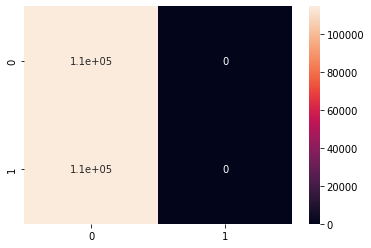

In [ ]:
sns.heatmap(cm_val, annot=True, )
plt.show()

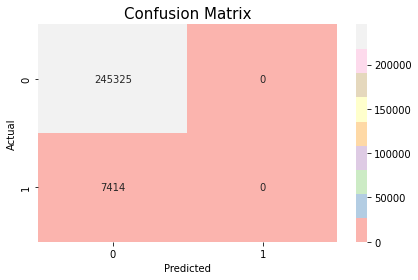

In [ ]:
sns.heatmap(cm_te, annot=True, cmap='Pastel1', fmt= 'g')
plt.title('Confusion Matrix', fontsize=15)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
pd.Series(preds_te.numpy()).unique()

array([0])

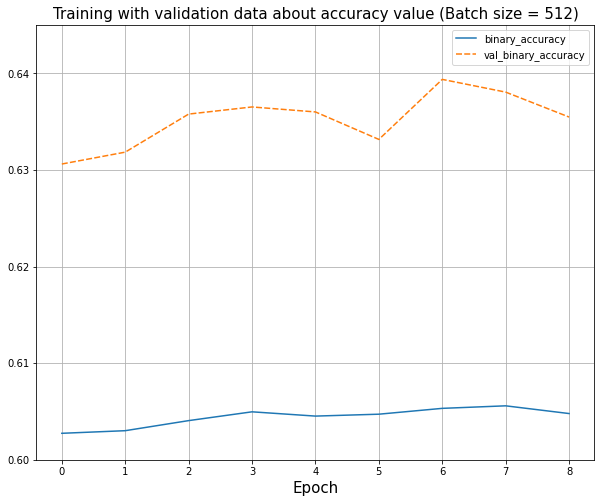

In [ ]:
plt.figure(figsize=(10, 8))
sns.lineplot(data= pd.DataFrame(history.history)[['binary_accuracy', 'val_binary_accuracy']])
plt.grid(True)
plt.gca().set_ylim(0.6, 0.645)
plt.xlabel('Epoch', fontsize=15)
plt.title('Training with validation data about accuracy value (Batch size = 512)', fontsize=15)
plt.show()

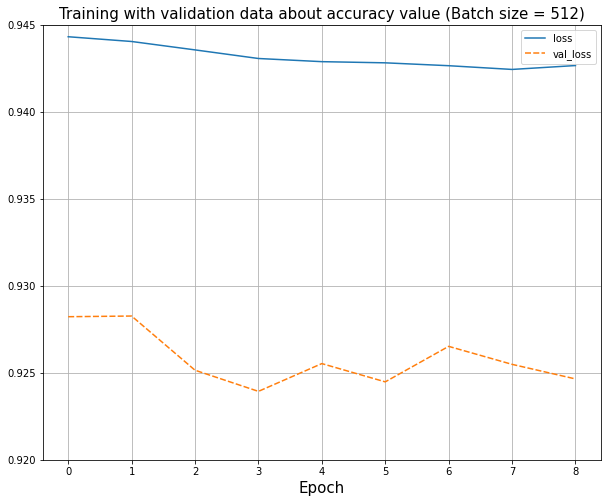

In [ ]:
plt.figure(figsize=(10, 8))
sns.lineplot(data= pd.DataFrame(history.history)[['loss', 'val_loss']])
plt.grid(True)
plt.gca().set_ylim(0.92, 0.945)
plt.xlabel('Epoch', fontsize=15)
plt.title('Training with validation data about accuracy value (Batch size = 512)', fontsize=15)
plt.show()

In [ ]:
cols = {'obj': [],
        'cat': [],
       'cont': []
        }
def data_split():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/'
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    # 데이터 유형별 분류하기
    for dt_idx, dt_val in zip(df.dtypes.index, df.dtypes.values):
        if dt_val == 'object':
            if ('id' in dt_idx) | ('time' in dt_idx) | ('name' in dt_idx) | ('keyword' in dt_idx) |('url' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                cols['obj'].append(dt_idx)

        else:
            if ('id' in dt_idx) | ('time' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                if len(df[dt_idx].value_counts()) <= 30: #연속형 데이터 중 30개 내의 범주로 나눌 수 있는 데이터 = category로 구분.
                    cols['cat'].append(dt_idx)
                else:
                    if ('hour' in dt_idx) | ('group' in dt_idx):
                        pass
                    else:
                        cols['cont'].append(dt_idx) 

    return cols

In [ ]:
def reorganization(df):
  data = pd.DataFrame()
  cols = data_split()
  for k, v in cols.items():
    if k == 'obj':
      data = pd.concat([data, df[v]], axis=1)
    elif k == 'cont':
      data = pd.concat([data, df[v]], axis=1)
    else:
      data = pd.concat([data, df[v]], axis=1)

  return data

In [ ]:
def preprocessing():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)
    
    # 데이터 유형별 분류하기
    data = reorganization(df)
    modified_df = pd.DataFrame()

    for i, c in enumerate(data.columns):
        if c in cols['obj']:
            obj_data = pd.get_dummies(data[c], prefix=c, prefix_sep = "/")
            modified_df = pd.concat([modified_df, obj_data], axis=1)

        elif c in cols['cat']:  # click_label 컬럼 = y 변수로 사용
            if 'click' in c:
                pass
            else:
                cat_data = pd.get_dummies(data[c], prefix=c, prefix_sep = "/")
                modified_df = pd.concat([modified_df, cat_data], axis=1)
        else:
            scaled_num_data = MinMaxScaler().fit_transform(df[[c]])
            scaled_num_data = pd.DataFrame(scaled_num_data, columns = [c])
            modified_df = pd.concat([modified_df,scaled_num_data], axis=1)
            
    print('---- Data info ----')
    print(cols)
    print('Data Frame shape: {}'.format(modified_df.shape))
    
    return modified_df

In [ ]:
# 데이터 7:3으로 나누기 (검증 데이터는 8:2)
def split_data():

  ### read dataset 
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    modified_df = preprocessing()

    X = modified_df.values
    y = df['click_label'].values
  
    # split the train/test data (7:3 ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2022, stratify = y) #y 비율에 따른 층화추출 및 데이터를 7:3의 비율로 나누기
    print(f"# of train_data's rows: {X_train.shape[0]} \n# of test_data's rows: {X_test.shape[0]}")
    print(f'train:test ratio = {round(X_train.shape[0]/(X_train.shape[0]+ X_test.shape[0]),2)}:{round(X_test.shape[0]/(X_train.shape[0]+ X_test.shape[0]), 2)}')

    ## create train and validation datasets (8:2 ratio)
    x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify = y_train)
    print(f"# of train_data's rows: {x_train.shape[0]} \n# of validation_data's rows: {x_val.shape[0]}")
    print(f'train:test ratio = {round(x_train.shape[0]/(x_train.shape[0]+ x_val.shape[0]),2)}:{round(x_val.shape[0]/(x_train.shape[0]+ x_val.shape[0]), 2)}')
   
    ## reshape the inputs
    x_train = x_train.reshape(-1, x_train.shape[1])
    x_val = x_val.reshape(-1, x_val.shape[1])

    return x_train, X_test, x_val, y_train, y_test, y_val

In [ ]:
x_train, X_test, x_val, y_train, y_test, y_val = split_data()

---- Data info ----
{'obj': ['user_gender'], 'cat': ['imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt'], 'cont': ['user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count']}
Data Frame shape: (842463, 101)
# of train_data's rows: 589724 
# of test_data's rows: 252739
train:test ratio = 0.7:0.3
# of train_data's rows: 471779 
# of validation_data's rows: 117945
train:test ratio = 0.8:0.2


In [ ]:
# Stacked autoencoder code
## input layer
input_layer = Input(shape=(x_train.shape[1],))
print(f"input layer's shape: {input_layer.shape}")

## encoding architecture
encode_layer1 = Dense(64, activation='relu', activity_regularizer = 'l2')(input_layer)
encode_layer1 = Dropout(0.4)(input_layer)
encode_layer2 = Dense(32, activation='relu', activity_regularizer = 'l2')(encode_layer1)
encode_layer2 = Dropout(0.2)(encode_layer1)
encode_layer3 = Dense(16, activation='relu', activity_regularizer = 'l2')(encode_layer2)
encode_layer3 = Dropout(0.1)(encode_layer2)

## latent view
latent_view  = Dense(2, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(16, activation='relu', activity_regularizer = 'l2')(latent_view)
decode_layer1 = Dropout(0.4)(latent_view)
decode_layer2 = Dense(32, activation='relu', activity_regularizer = 'l2')(decode_layer1)
decode_layer3 = Dense(64, activation='relu', activity_regularizer = 'l2')(decode_layer2)

## output layer
output_layer  = Dense(x_train.shape[1])(decode_layer3)
print(f"output layer's shape: {output_layer.shape}")

layer_loss = tf.losses.mean_squared_error(input_layer, output_layer)
print(f"MSE of Autoencoder model: {layer_loss}")

model = tf.keras.Model(input_layer, output_layer)
print(model.summary())

input layer's shape: (None, 101)
output layer's shape: (None, 101)
MSE of Autoencoder model: KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name=None), name='tf.math.reduce_mean_1/Mean:0', description="created by layer 'tf.math.reduce_mean_1'")
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 101)]             0         
                                                                 
 dropout_3 (Dropout)         (None, 101)               0         
                                                                 
 dropout_4 (Dropout)         (None, 101)               0         
                                                                 
 dropout_5 (Dropout)         (None, 101)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                 204 

In [ ]:
# 드롭아웃을 encoding에 시켰을 때
# patience: patience 는 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 정의

learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto') 
start = perf_counter()
history = model.fit(x_train, y_train, epochs=200, batch_size=512, validation_data=(x_val, y_val), callbacks=[early_stopping])
print("End of Training")
print("걸린 시간: {:g}분 {:.2f}초".format((perf_counter() - start)//60, round((perf_counter() - start)%60)))

Epoch 1/200
922/922 [==============================] - 5s 5ms/step - loss: 0.1914 - binary_accuracy: 0.9707 - val_loss: 0.1901 - val_binary_accuracy: 0.9707
Epoch 2/200
922/922 [==============================] - 4s 5ms/step - loss: 0.1899 - binary_accuracy: 0.9707 - val_loss: 0.1895 - val_binary_accuracy: 0.9707
Epoch 3/200
922/922 [==============================] - 4s 5ms/step - loss: 0.1900 - binary_accuracy: 0.9707 - val_loss: 0.1895 - val_binary_accuracy: 0.9707
Epoch 4/200
922/922 [==============================] - 4s 5ms/step - loss: 0.1898 - binary_accuracy: 0.9707 - val_loss: 0.1895 - val_binary_accuracy: 0.9707
Epoch 5/200
922/922 [==============================] - 5s 5ms/step - loss: 0.1898 - binary_accuracy: 0.9707 - val_loss: 0.1913 - val_binary_accuracy: 0.9707
Epoch 6/200
922/922 [==============================] - 4s 5ms/step - loss: 0.1899 - binary_accuracy: 0.9707 - val_loss: 0.1898 - val_binary_accuracy: 0.9707
Epoch 7/200
922/922 [==============================] - 4s 

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("테스트 데이터 정확도", accuracy)

7899/7899 [==============================] - 21s 3ms/step - loss: 0.1896 - binary_accuracy: 0.9707
테스트 데이터 정확도 0.9706653952598572


In [ ]:
loss, accuracy = model.evaluate(x_val, y_val)
print("검증 데이터 정확도", accuracy)

3686/3686 [==============================] - 10s 3ms/step - loss: 0.1896 - binary_accuracy: 0.9707
검증 데이터 정확도 0.9706643223762512


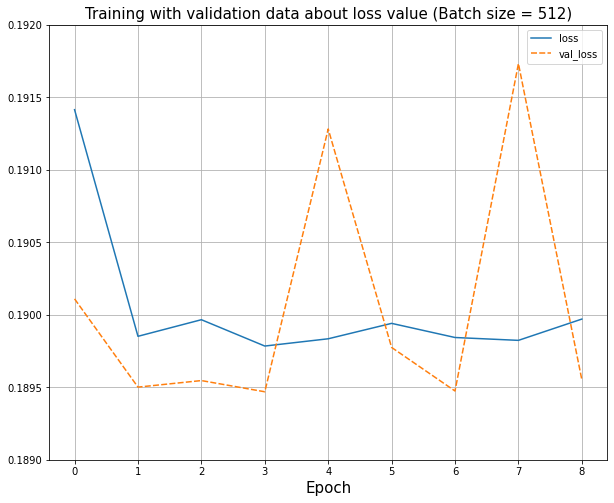

In [ ]:
plt.figure(figsize=(10, 8))
sns.lineplot(data= pd.DataFrame(history.history)[['loss', 'val_loss']])
plt.grid(True)
plt.gca().set_ylim(0.189, 0.192)
plt.xlabel('Epoch', fontsize=15)
plt.title('Training with validation data about loss value (Batch size = 512)', fontsize=15)
plt.show()

In [ ]:
cols = {'obj': [],
        'cat': [],
       'cont': []
        }
def data_split():
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/'
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    # 데이터 유형별 분류하기
    for dt_idx, dt_val in zip(df.dtypes.index, df.dtypes.values):
        if dt_val == 'object':
            if ('id' in dt_idx) | ('time' in dt_idx) | ('name' in dt_idx) | ('keyword' in dt_idx) |('url' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                cols['obj'].append(dt_idx)

        else:
            if ('id' in dt_idx) | ('time' in dt_idx):
                df.drop(columns = dt_idx, axis=1, inplace=True)
            else:
                if len(df[dt_idx].value_counts()) <= 30: #연속형 데이터 중 30개 내의 범주로 나눌 수 있는 데이터 = category로 구분.
                    cols['cat'].append(dt_idx)
                else:
                    if ('hour' in dt_idx) | ('group' in dt_idx):
                        pass
                    else:
                        cols['cont'].append(dt_idx) 

    return cols

In [ ]:
def reorganization(df):
  data = pd.DataFrame()
  cols = data_split()
  for k, v in cols.items():
    if k == 'obj':
      data = pd.concat([data, df[v]], axis=1)
    elif k == 'cont':
      data = pd.concat([data, df[v]], axis=1)
    else:
      data = pd.concat([data, df[v]], axis=1)

  return data

In [ ]:
# 데이터 7:3으로 나누기 (검증 데이터는 8:2)
def split_data():

  ### read dataset 
    file_name = 'final_data_v2.csv'
    file_path = os.getcwd()+'/drive/MyDrive/Colab Notebooks/' 
    df = pd.read_csv(file_path+file_name, encoding='utf-8')
    df.rename(columns={'category_id_1':'category1'}, inplace=True)

    modified_df = preprocessing()

    X = modified_df
    y = df['click_label']

    # split the train/test data (7:3 ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2022, stratify = y) #y 비율에 따른 층화추출 및 데이터를 7:3의 비율로 나누기
    print(f"# of train_data's rows: {X_train.shape[0]} \n# of test_data's rows: {X_test.shape[0]}")
    print(f'train:test ratio = {round(X_train.shape[0]/(X_train.shape[0]+ X_test.shape[0]),2)}:{round(X_test.shape[0]/(X_train.shape[0]+ X_test.shape[0]), 2)}')
    
    ## create train and validation datasets (8:2 ratio)
    x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 2022, stratify = y_train)
    print(f"# of train_data's rows: {x_train.shape[0]} \n# of validation_data's rows: {x_val.shape[0]}")
    print(f'train:test ratio = {round(x_train.shape[0]/(x_train.shape[0]+ x_val.shape[0]),2)}:{round(x_val.shape[0]/(x_train.shape[0]+ x_val.shape[0]), 2)}')
   
    ## reshape the inputs
    x_train = x_train.values.reshape(-1, x_train.shape[1])
    x_val = x_val.values.reshape(-1, x_val.shape[1])

    return x_train, X_test, x_val, y_train, y_test, y_val

x_train, X_test, x_val, y_train, y_test, y_val = split_data()

---- Data info ----
{'obj': ['user_gender'], 'cat': ['imp_hour', 'click_label', 'user_age_group', 'flag_used', 'category1', 'emergency_cnt'], 'cont': ['user_age', 'user_following_cnt', 'user_pay_count', 'user_parcel_post_count', 'user_transfer_count', 'user_chat_count', 'price', 'comment_cnt', 'ad_interest', 'ad_pfavcnt', 'adver_favorite_count', 'adver_grade', 'adver_item_count', 'adver_interest', 'adver_review_count', 'adver_comment_count', 'adver_pay_count', 'adver_parcel_post_count', 'adver_transfer_count', 'adver_chat_count']}
Data Frame shape: (842463, 101)
# of train_data's rows: 589724 
# of test_data's rows: 252739
train:test ratio = 0.7:0.3
# of train_data's rows: 471779 
# of validation_data's rows: 117945
train:test ratio = 0.8:0.2


In [ ]:
# Stacked autoencoder code
## input layer
input_layer = Input(shape=(x_train.shape[1],))
print(f"input layer's shape: {input_layer.shape}")

## encoding architecture
encode_layer1 = Dense(64, activation='relu', activity_regularizer = 'l2')(input_layer)
encode_layer1 = Dropout(0.4)(input_layer)
encode_layer2 = Dense(32, activation='relu', activity_regularizer = 'l2')(encode_layer1)
encode_layer2 = Dropout(0.2)(encode_layer1)
encode_layer3 = Dense(16, activation='relu', activity_regularizer = 'l2')(encode_layer2)
encode_layer3 = Dropout(0.1)(encode_layer2)

## latent view
latent_view  = Dense(2, activation='sigmoid')(encode_layer3)

## decoding architecture
decode_layer1 = Dense(16, activation='relu', activity_regularizer = 'l2')(latent_view)
decode_layer1 = Dropout(0.4)(latent_view)
decode_layer2 = Dense(32, activation='relu', activity_regularizer = 'l2')(decode_layer1)
decode_layer3 = Dense(64, activation='relu', activity_regularizer = 'l2')(decode_layer2)

## output layer
output_layer  = Dense(x_train.shape[1])(decode_layer3)
print(f"output layer's shape: {output_layer.shape}")

layer_loss = tf.losses.mean_squared_error(input_layer, output_layer)
print(f"MSE of Autoencoder model: {layer_loss}")

model = tf.keras.Model(input_layer, output_layer)
print(model.summary())

input layer's shape: (None, 101)
output layer's shape: (None, 101)
MSE of Autoencoder model: KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name=None), name='tf.math.reduce_mean_1/Mean:0', description="created by layer 'tf.math.reduce_mean_1'")
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 101)]             0         
                                                                 
 dropout_4 (Dropout)         (None, 101)               0         
                                                                 
 dropout_5 (Dropout)         (None, 101)               0         
                                                                 
 dropout_6 (Dropout)         (None, 101)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                 204 

In [ ]:
# 드롭아웃을 encoding에 시켰을 때
# patience: patience 는 성능이 증가하지 않는 epoch 을 몇 번이나 허용할 것인가를 정의
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto') 
start = perf_counter()
history = model.fit(x_train, y_train, epochs=200, batch_size=512, validation_data=(x_val, y_val), callbacks=[early_stopping])
print("End of Training")
print("걸린 시간: {:g}분 {:.2f}초".format((perf_counter() - start)//60, round((perf_counter() - start)%60)))

Epoch 1/200
922/922 [==============================] - 8s 8ms/step - loss: 0.2044 - binary_accuracy: 0.9707 - val_loss: 0.2022 - val_binary_accuracy: 0.9707
Epoch 2/200
922/922 [==============================] - 7s 8ms/step - loss: 0.2026 - binary_accuracy: 0.9707 - val_loss: 0.2024 - val_binary_accuracy: 0.9707
Epoch 3/200
922/922 [==============================] - 7s 8ms/step - loss: 0.2025 - binary_accuracy: 0.9707 - val_loss: 0.2022 - val_binary_accuracy: 0.9707
Epoch 4/200
922/922 [==============================] - 7s 8ms/step - loss: 0.2025 - binary_accuracy: 0.9707 - val_loss: 0.2031 - val_binary_accuracy: 0.9707
Epoch 5/200
922/922 [==============================] - 7s 7ms/step - loss: 0.2025 - binary_accuracy: 0.9707 - val_loss: 0.2022 - val_binary_accuracy: 0.9707
Epoch 6/200
922/922 [==============================] - 7s 7ms/step - loss: 0.2025 - binary_accuracy: 0.9707 - val_loss: 0.2027 - val_binary_accuracy: 0.9707
Epoch 7/200
922/922 [==============================] - 7s 

In [ ]:
# create Tensorflow datatset
batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# shuffle and prepare batched dataset
train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)
train_dataset = test_dataset.batch(batch_size)

print(iter(train_dataset).__next__()) 
print(iter(test_dataset).__next__()) 

(<tf.Tensor: shape=(512, 101), dtype=float64, numpy=
array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.42184154e-02, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        3.74087591e-02, 0.00000000e+00, 6.82593857e-04],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.28265525e-03, 7.50853242e-03],
       ...,
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 7.50853242e-03],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        1.82481752e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.37687366e-01, 2.04778157e-03]])>, <tf.Tensor: shape=(512,), dtype=int64, numpy=
array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
train_labels = X_test.astype(bool)
test_labels = y_test.astype(bool) #creating normal and fraud datasets 
true_train_data = X_test[~train_labels] 
true_test_data = y_test[~test_labels] 
false_train_data = X_test[train_labels] 
false_test_data = y_test[test_labels] 
print(" No. of records in Fraud Train Data=",len(false_train_data)) 
print(" No. of records in Normal Train data=",len(true_train_data)) 
print(" No. of records in Fraud Test Data=",len(false_test_data)) 
print(" No. of records in Normal Test data=",len(true_test_data))

 No. of records in Fraud Train Data= 252739
 No. of records in Normal Train data= 252739
 No. of records in Fraud Test Data= 7414
 No. of records in Normal Test data= 245325


In [ ]:
pred_y = model.predict(X_test) 
mse = tf.keras.metrics.mean_squared_error(X_test, pred_y)
result_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': test_labels})
result_df = pd.concat([error_df, result_df], axis=1)
result_df

,Reconstruction_error,True_class,click_label
24417,0.073019,False,0
837998,0.063128,True,1
445289,0.062405,False,0
634064,0.062290,False,0
620178,0.068503,False,0
...,...,...,...
551496,0.067845,False,0
220758,0.062176,False,0
516393,0.066118,False,0
402268,0.063068,False,0


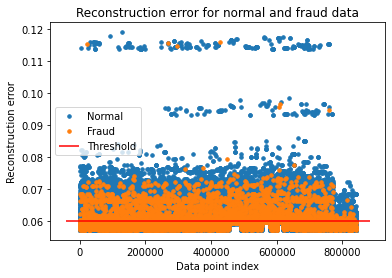

In [ ]:
thresholds = 0.06
groups = result_df.groupby('True_class') 
fig, ax = plt.subplots() 
for name, group in groups: 
  ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='', label= "Fraud" if name == 1 else "Normal") 
ax.hlines(thresholds, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold') 
ax.legend() 
plt.title("Reconstruction error for normal and fraud data") 
plt.ylabel("Reconstruction error") 
plt.xlabel("Data point index") 
plt.show();

In [ ]:
error_df.groupby('True_class').mean()

,Reconstruction_error
True_class,
False,0.060659
True,0.060499


[[ 51528 193797]
 [  1853   5561]]


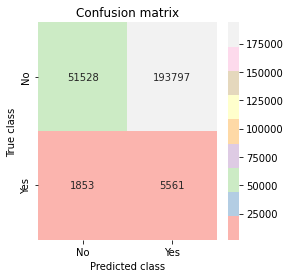

              precision    recall  f1-score   support

       False       0.97      0.21      0.35    245325
        True       0.03      0.75      0.05      7414

    accuracy                           0.23    252739
   macro avg       0.50      0.48      0.20    252739
weighted avg       0.94      0.23      0.34    252739

ROC-AUC: 0.480053591588109
[[204788  40537]
 [  6256   1158]]


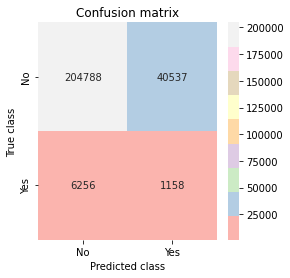

              precision    recall  f1-score   support

       False       0.97      0.83      0.90    245325
        True       0.03      0.16      0.05      7414

    accuracy                           0.81    252739
   macro avg       0.50      0.50      0.47    252739
weighted avg       0.94      0.81      0.87    252739

ROC-AUC: 0.49547652018013355
[[234663  10662]
 [  7068    346]]


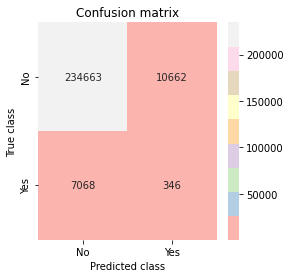

              precision    recall  f1-score   support

       False       0.97      0.96      0.96    245325
        True       0.03      0.05      0.04      7414

    accuracy                           0.93    252739
   macro avg       0.50      0.50      0.50    252739
weighted avg       0.94      0.93      0.94    252739

ROC-AUC: 0.5016038748442654
[[244379    946]
 [  7401     13]]


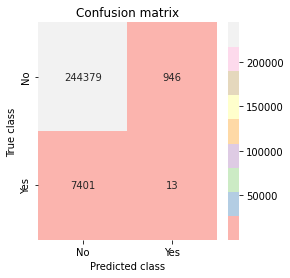

              precision    recall  f1-score   support

       False       0.97      1.00      0.98    245325
        True       0.01      0.00      0.00      7414

    accuracy                           0.97    252739
   macro avg       0.49      0.50      0.49    252739
weighted avg       0.94      0.97      0.95    252739

ROC-AUC: 0.49894866509802915
[[244927    398]
 [  7407      7]]


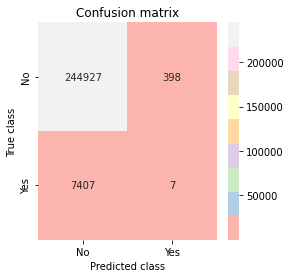

              precision    recall  f1-score   support

       False       0.97      1.00      0.98    245325
        True       0.02      0.00      0.00      7414

    accuracy                           0.97    252739
   macro avg       0.49      0.50      0.49    252739
weighted avg       0.94      0.97      0.96    252739

ROC-AUC: 0.49966091099129667
[[245001    324]
 [  7407      7]]


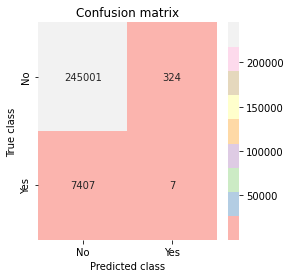

              precision    recall  f1-score   support

       False       0.97      1.00      0.98    245325
        True       0.02      0.00      0.00      7414

    accuracy                           0.97    252739
   macro avg       0.50      0.50      0.49    252739
weighted avg       0.94      0.97      0.96    252739

ROC-AUC: 0.4998117313316615


In [ ]:
# test data confusion matrix (최종 결과용)
thresholds = [0.06, 0.065, 0.07, 0.075, 0.08, 0.085]#[i/1000 for i in range(50, 100)] 
for thr in thresholds:
    pred_y = [1 if e > thr else 0 for e in result_df.Reconstruction_error.values]  
    error_df['pred'] = pred_y
    cm = confusion_matrix(result_df.True_class, pred_y) 
    print(cm)
    LABELS = ['No', 'Yes']
    plt.figure(figsize=(4, 4)) 
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="g", cmap='Pastel1'); plt.title("Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show() 
    print(classification_report(result_df.True_class, pred_y))
    print('ROC-AUC:', roc_auc_score(result_df.True_class, pred_y))